I'm going to forecast the crimes committed in boroughs of London.I will be using the dataset from June 2018 to May 2020 and forecast the crimes committed in London for the next 12 months.

Content

- Cleaning and restructuring the data set to make it more user friendly to carry out the time series analysis
- Visualisation the time series
- Make the time series data stationary
- Use ACF and PACF to pick the order for the model
- forecasting by building ARIMA Model or Seasonal ARIMA based on the data
- use the model to predict the crime 


In [125]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [126]:
# upload the csv file from https://data.london.gov.uk/dataset/recorded_crime_summary
# file name MPS Borough Level Crime (most recent 24 months)
data = pd.read_csv('Borough_crime.csv')

In [127]:
data = data.melt(id_vars=['MajorText', 'MinorText', 'LookUp_BoroughName'],var_name='YYYYMM',value_name='Value')

In [128]:
#check the data
data.head()

,MajorText,MinorText,LookUp_BoroughName,YYYYMM,Value
0,Arson and Criminal Damage,Arson,Barking and Dagenham,201806,12
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,201806,123
2,Burglary,Burglary - Business and Community,Barking and Dagenham,201806,33
3,Burglary,Burglary - Residential,Barking and Dagenham,201806,77
4,Drug Offences,Drug Trafficking,Barking and Dagenham,201806,6


### 1. Restructuring the data set to help carry out forecasting

In [129]:
df = data.groupby('YYYYMM').sum() #groupby the data by Year and Month, so total of 24 Months

In [130]:
df= df.reset_index()

In [131]:
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'],format = '%Y%m', errors = 'coerce') # changing dtypes

In [132]:
df = df.set_index('YYYYMM') # set date to index

Text(0.5, 0, 'Month and Year')

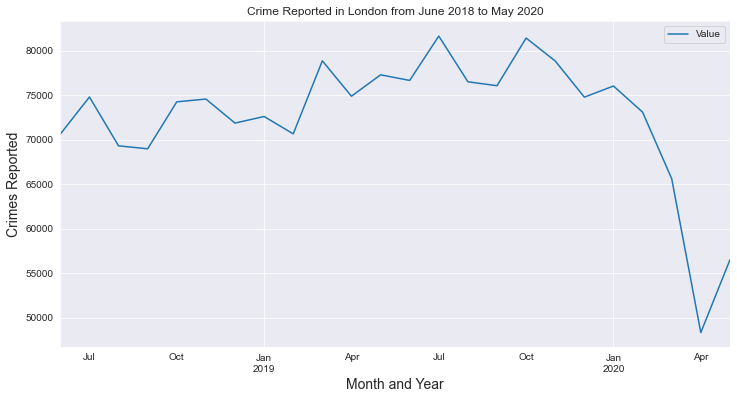

In [133]:
sns.set_style('darkgrid')
df.plot(figsize=(12,6),title='Crime Reported in London from June 2018 to May 2020')
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

### 2. Is the data Stationary?

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

It is similar to Regression Models, where the assumption is that variable are independent of each other.

To check the Stationary, we will be using dickey fuller test. 

In [45]:
#library
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(df['Value'])

# Print test statistic
print('test statistic :',result[0])

# Print p-value
print('p-value :',result[1])
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

# Print critical values
print(result[4]) 

test statistic : -2.150043516980518
p-value : 0.22487343408903449
{'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}


No sufficient evidence to reject the null hypothesis (H0), the data does have a unit root and is not stationary.

To make the data stationary we can take the following steps:
    - Take the difference of the data set by using shift(1) method or seasonal rolling shift(3)
    - carrying out de-trend
    - Take the log np.log()
    - Take the sqrt np.sqrt()
    - Take the proportional change df.shift()/df

After carrying out all of the steps above de-trend seemed to be more reasonable. 

In [46]:
#de-trend
df['z_data'] = (df['Value'] - df.Value.rolling(window=3).mean()) / df.Value.rolling(window=3).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(3)

Text(0.5, 0, 'Month and Year')

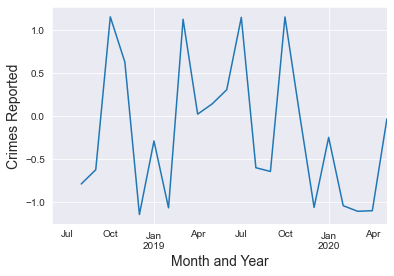

In [47]:
df.z_data.plot()
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

Text(0.5, 0, 'Month and Year')

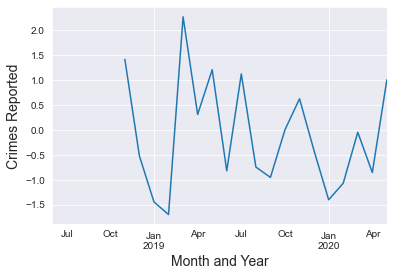

In [48]:
df.zp_data.plot()
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

In [49]:
# back to dickey fuller test

In [50]:
# Run test
result = adfuller(df.z_data.dropna(), autolag='AIC')

# Print test statistic
print(result[0])

# Print p-value
print(result[1])
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

# Print critical values
print(result[4]) 

-4.138995875682196
0.0008343495280424233
{'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}


Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [51]:
# Run test
result = adfuller(df.zp_data.dropna(), autolag='AIC')

# Print test statistic
print(result[0])

# Print p-value
print(result[1])
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

# Print critical values
print(result[4]) 


-4.490609482928958
0.00020446700172363218
{'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}


Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

### Use ACF and PACF to pick the order for the model

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


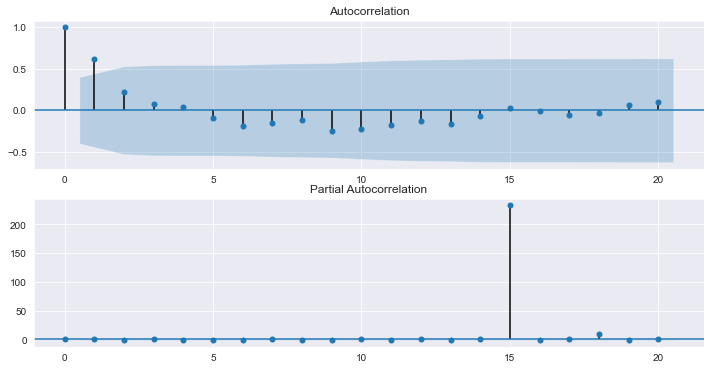

In [52]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.Value, ax=ax[0], lags=20)
ax[1] = plot_pacf(df.Value, ax=ax[1], lags=20)

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


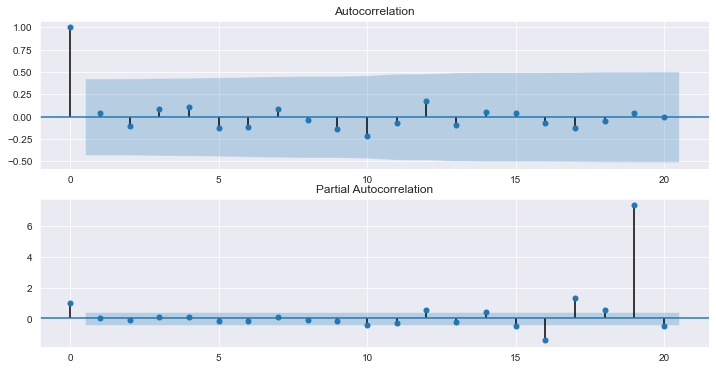

In [53]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.iloc[3:], ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.iloc[3:], ax=ax[1], lags=20)

I will be using AR(1) and for MA 0 or 1

In [54]:
from statsmodels.tsa.arima_model import ARIMA

In [55]:
model=ARIMA(df.Value,order=(1,0,1))
model_fit=model.fit()

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [56]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                   24
Model:                     ARMA(1, 1)   Log Likelihood                -239.921
Method:                       css-mle   S.D. of innovations           5230.193
Date:                Fri, 26 Jun 2020   AIC                            487.842
Time:                        09:40:59   BIC                            492.554
Sample:                    06-01-2018   HQIC                           489.092
                         - 05-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         7.13e+04   3701.820     19.261      0.000     6.4e+04    7.86e+04
ar.L1.Value     0.6797      0.306      2.221      0.026       0.080       1.280
ma.L1.Value     0.0905      0.385      0.235      0.814      -0.665       0.846
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4712           +0.0000j            1.4712            0.0000
MA.1          -11.0547           +0.0000j           11.0547            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 0, 'Month and Year')

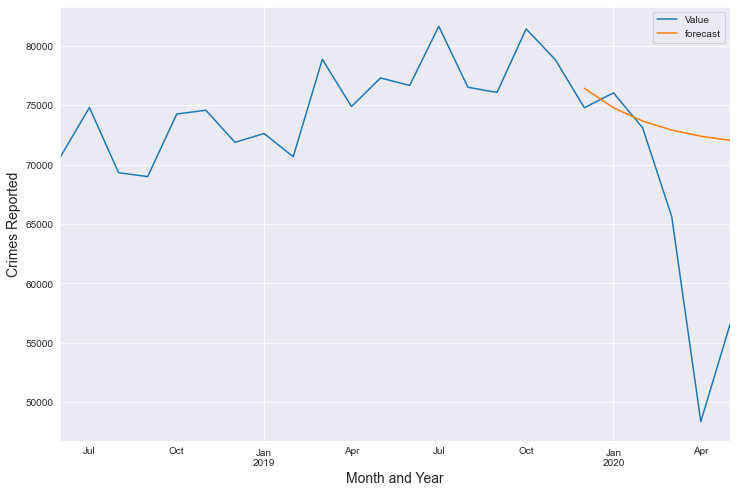

In [75]:
df['forecast']=model_fit.predict(start=18,end=36,dynamic=True)
df[['Value','forecast']].plot(figsize=(12,8))
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

### Seasonal ARIMA

In [59]:
import statsmodels.api as sm

In [60]:
model=sm.tsa.statespace.SARIMAX(df['Value'],order=(1, 0, 1),seasonal_order=(1,0,1,3))
results=model.fit()

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 0, 'Month and Year')

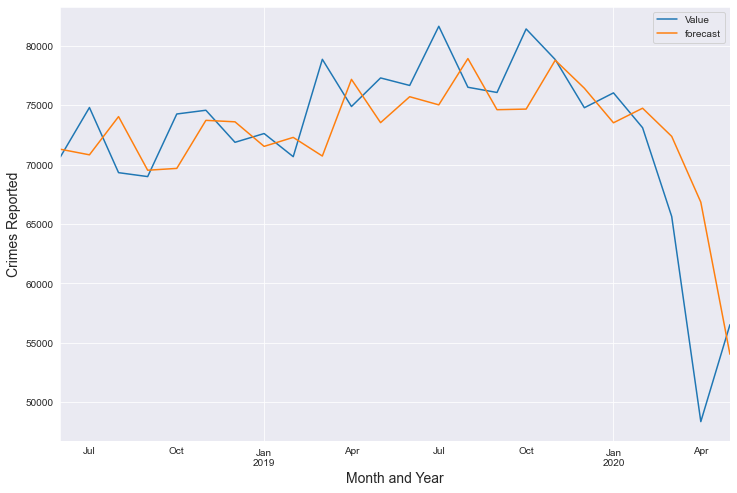

In [76]:
df['forecast']=model_fit.predict()
df[['Value','forecast']].plot(figsize=(12,8))
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

In [77]:
predictions = pd.Series(results.fittedvalues, copy=True)
predictions.loc['2018-07-01':]

YYYYMM
2018-07-01    70386.215259
2018-08-01    73993.982576
2018-09-01    69879.240621
2018-10-01    68334.341230
2018-11-01    74073.501502
2018-12-01    74468.493663
2019-01-01    70682.814041
2019-02-01    72845.923393
2019-03-01    71409.498688
2019-04-01    76314.886152
2019-05-01    75889.074646
2019-06-01    75952.111925
2019-07-01    76030.365180
2019-08-01    81058.917470
2019-09-01    76293.391995
2019-10-01    74622.340747
2019-11-01    81673.398681
2019-12-01    78571.990195
2020-01-01    72894.247668
2020-02-01    77212.903242
2020-03-01    73937.683259
2020-04-01    64373.649422
2020-05-01    52738.655969
dtype: float64

Text(0.5, 0, 'Month and Year')

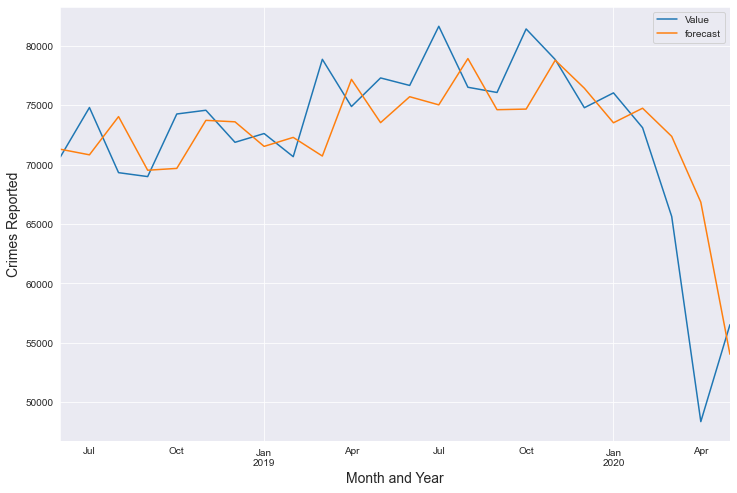

In [122]:
df['forecast']=model_fit.predict()
df[['Value','forecast']].plot(figsize=(12,8))
plt.ylabel('Crimes Reported',fontsize=14)
plt.xlabel('Month and Year',fontsize=14)

### Prediction for next 12 month 

In [79]:
# Furture prediction from June 2020 to May 2021

In [92]:
from pandas.tseries.offsets import DateOffset
crime_next_12month=[df.index[-1]+ DateOffset(months=x)for x in range(0,13)]

In [94]:
crime_next_12month=pd.DataFrame(index=future_dates[1:],columns=df.columns)#

In [95]:
crime_next_12month.tail()

,Value,z_data,zp_data,forecast
2021-01-01,NaN,NaN,NaN,NaN
2021-02-01,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN,NaN


In [96]:
forecast_df=pd.concat([df,crime_next_12month])

In [100]:
# forecast_df['forecast'] = results.predict(start =23, end = 36, dynamic= True)  
# forecast_df[['Value', 'forecast']].plot(figsize=(12, 8))

In [102]:
future_values = results.get_forecast(steps=12)

In [103]:
future_confidence_interval = future_values.conf_int()

In [104]:
future_values.summary_frame()

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-06-01,57772.543033,5674.387904,46650.947106,68894.138960
2020-07-01,59336.643109,7462.284399,44710.834445,73962.451774
2020-08-01,59421.068140,8897.085212,41983.101557,76859.034723
2020-09-01,60761.365550,9600.474503,41944.781290,79577.949810
2020-10-01,61821.006205,10311.064970,41611.690221,82030.322189
2020-11-01,61874.800516,10975.389449,40363.432480,83386.168552
2020-12-01,62782.306790,11355.644791,40525.651978,85038.961601
2021-01-01,63499.030059,11747.113223,40475.111220,86522.948898
2021-02-01,63532.004161,12125.766335,39765.938858,87298.069463
2021-03-01,64145.311398,12365.636517,39909.109179,88381.513617


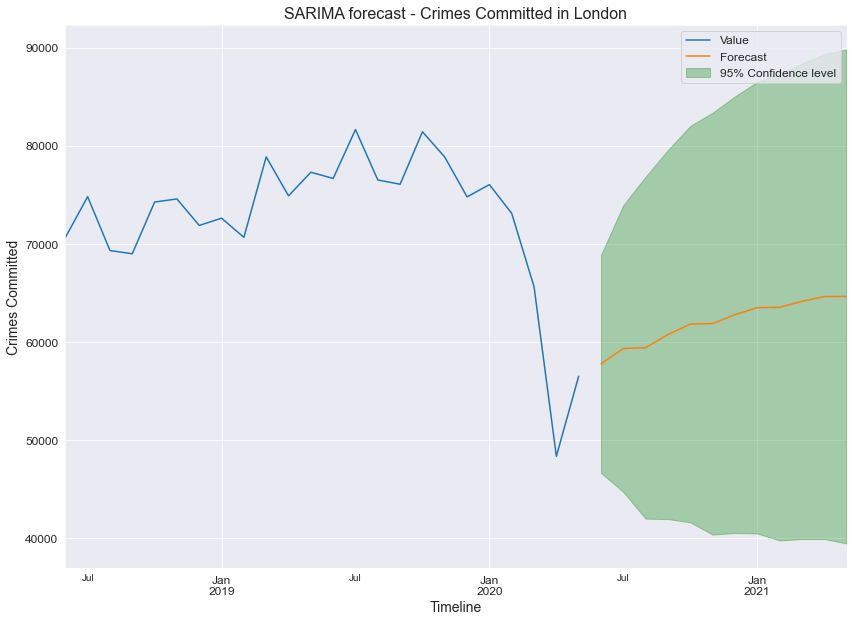

In [123]:
ax = df['Value'].plot()

#plot prediction
future_values.predicted_mean.plot(ax=ax,figsize=(14,10),label='Forecast')

# plot confidence interval 
ax.fill_between(future_confidence_interval.index,
                 future_confidence_interval.iloc[:,0],
                future_confidence_interval.iloc[:,1],color='g',alpha=.3 ,label='95% Confidence level')

ax.set_xlabel('Timeline',fontsize=14)
ax.set_ylabel('Crimes Committed',fontsize=14)
ax.set_title('SARIMA forecast - Crimes Committed in London',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=12)

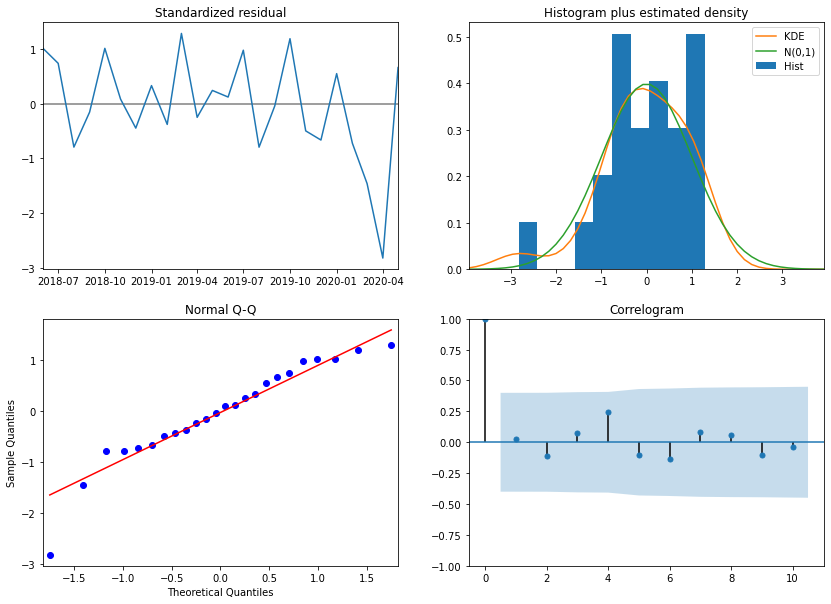

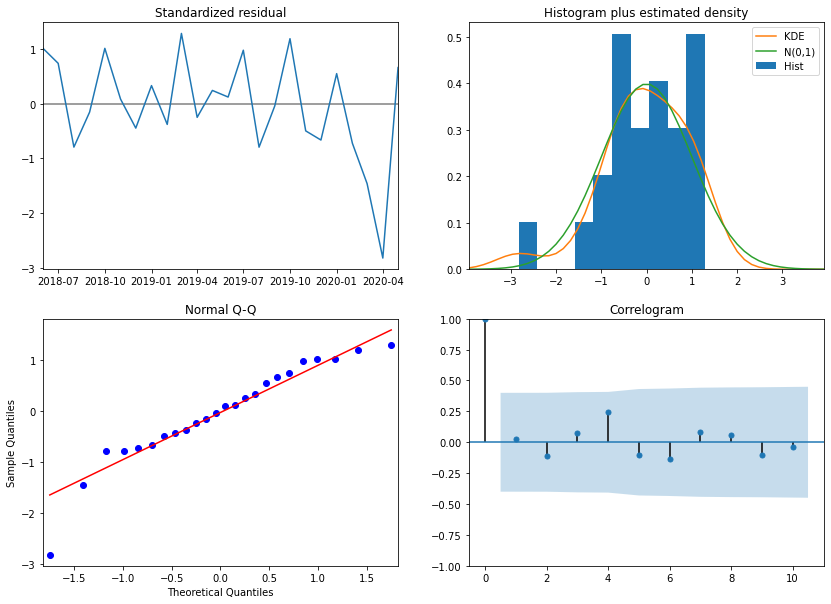

In [246]:
results.plot_diagnostics(figsize=(14,10))